1. Difficulty evaluation using trajectory rewards

Visualization of the state

In [1]:
% load_ext autoreload
% autoreload 2

from copy import copy

import matplotlib
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU

from framework import TrajectoryRewardsEvaluator, QEvaluator, DQNAgent
from pendulum import PendulumEnvironment, PendulumRenderer, PendulumState
from pendulum.heuristic import *
from shared_parameters import *
from utils import mean, running_average
from utils import save, load, set_matplotlib_colors

set_matplotlib_colors(matplotlib, text_color="black", label_color="white")
import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode=False)

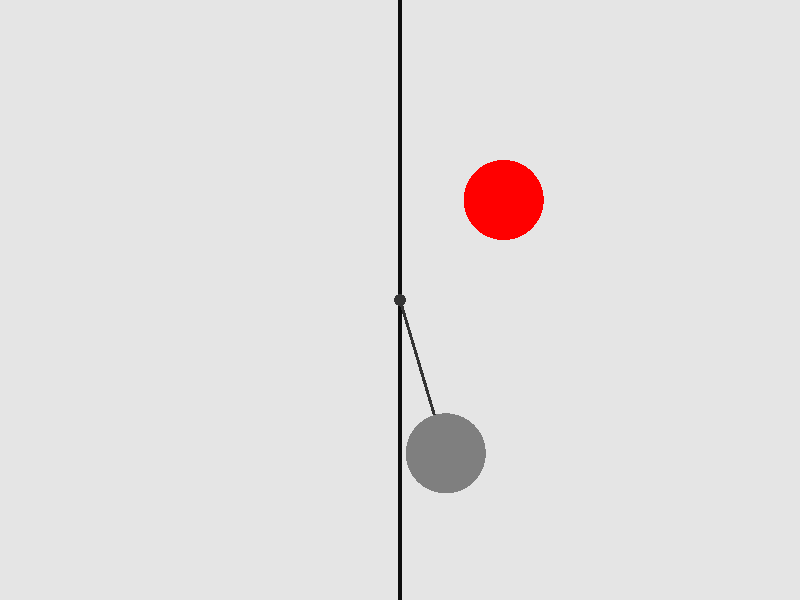

In [2]:
env = PendulumEnvironment(*pendulum_env_args, time_scale=5, step_reward=1.0, action_reward=-0.1, death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

renderer.render(env.get_starting_state(), to_image=True)


### Note for all difficulty estimators

Currently, we have a small embedding space (just one dimension),
thus it's possible to pre-evaluate it directly, and then use the
cached difficulty evaluations.

Within the bigger space it's not possible, and we will have to
come up with some clever way of caching, where we don't store the
evaluation for every point space, but neither perform an evaluation
each time for each point.

### Direct difficulty estimation

In [5]:
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
difficulty = oracle(state)

print(state.to_string())
print(f"difficulty: {difficulty.item():.3f}")

NameError: name 'HeuristicPendulumEvaluator' is not defined

### Difficulty estimation using trajectory rewards

In [9]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
oracle.evaluate(states)

tensor([0.2954, 0.0762, 0.7320, 0.9072, 0.6382, 0.8839, 0.1979, 0.8172, 0.7571,
        0.8782])

### Difficulty estimation using Q-values

1. Train agents, save at time steps
2. Use them in QEvaluator

In [245]:
agent = DQNAgent(PendulumState.get_size(1), action_size=2, hidden=[8, 8], activation=LeakyReLU())
total_rewards = []
agents = []

Run next cell to train the agent until you're satisfied. Run the cell above it to save the agent

loss: 74.70817565917969. Mean total reward: -6.379662921348304


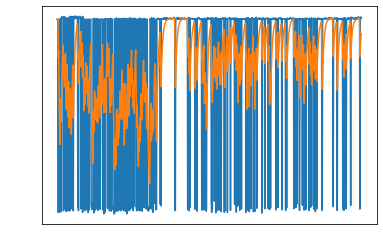

In [334]:
# Train the agent for N iterations
agent.eval = False
loss = agent.train(env, epochs=100, max_trajectory_length=20)
agent.eval = True

for _ in range(10):
    state = env.get_starting_state()
    total_reward = 0.0

    for _ in range(20):
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward
        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

clear_output(wait=True)
print(f"loss: {loss}. Mean total reward: {mean(total_rewards)}")
plt.plot(total_rewards)
plt.plot(running_average(total_rewards))
plt.show()

In [335]:
# Use this to append an agent
original = agent
agents.append(copy(agent))
print(f"Total of: {len(agents)} agents")
save(agents, "./saved_data/saved_agents.pt")

for agent in agents:
    print(list(agent.nn.parameters())[0].data)

agent = original

Total of: 1 agents
tensor([[-0.9580, -0.3120, -0.2828,  0.1436],
        [-0.9184, -2.8424, -0.8167,  0.4843],
        [-2.1922,  2.9781, -1.6350, -5.8470],
        [-1.6450,  6.3687,  1.9850,  5.0101],
        [-0.1670,  1.4488, -3.5070,  0.1933],
        [ 0.3482,  0.4908, -0.0913, -0.1252],
        [ 1.1303, -7.1345,  0.6171, -5.6739],
        [-1.2939, -6.1549,  0.3190,  3.3671]])


Now we have our agents, let's run the evaluator

In [31]:
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle = QEvaluator(env, 2, agents, weights, num_evaluations=1, max_trajectory_length=20)
oracle(env.get_starting_state())

tensor(0.0831)

### Evaluators comparison

In [349]:
# Heuristic evaluator
oracle_h = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

# Trajectory rewards evaluator
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle_r = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

# Q-Evaluator
agents = load("./saved_data/saved_agents.pt")
for agent in agents:
    agent.eval = True
    print(list(agent.nn.parameters())[0].data)

weights = [1.0]
oracle_q = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)

print("Difficulty evaluation of the same random state:")

state = env.get_starting_state()
print(f"State: {state}")
print()

print(f"Heuristic: {oracle_h(state).item():.4f}")
print(f"Trajectory Rewards: {oracle_r(state).item():.4f}")
print(f"Q-Evaluator: {oracle_q(state).item():.4f}")

print()
print("Difficulty of several states:")

states = torch.vstack([env.get_starting_state() for _ in range(5)])
print(f"H: {oracle_h(states)}")
print(f"R: {oracle_r(states)}")
print(f"Q: {oracle_q(states)}")

print()
print("Difficulty of the whole range")

states = []
# evaluations_h = []
# evaluations_r = []
evaluations_q = []
state = env.get_starting_state()
num_states = 26
for i, x in enumerate(torch.linspace(enemy_x_min, enemy_x_max, num_states)):
    print(f"Evaluating {i + 1}/{num_states}...")
    s = state.clone()
    s.enemy_x = x
    states.append(x)

    evaluations_h.append(oracle_h(s))
    evaluations_r.append(oracle_r(s))
    evaluations_q.append(oracle_q(s))

print("Done")

tensor([[-0.9580, -0.3120, -0.2828,  0.1436],
        [-0.9184, -2.8424, -0.8167,  0.4843],
        [-2.1922,  2.9781, -1.6350, -5.8470],
        [-1.6450,  6.3687,  1.9850,  5.0101],
        [-0.1670,  1.4488, -3.5070,  0.1933],
        [ 0.3482,  0.4908, -0.0913, -0.1252],
        [ 1.1303, -7.1345,  0.6171, -5.6739],
        [-1.2939, -6.1549,  0.3190,  3.3671]])
Difficulty evaluation of the same random state:
State: tensor([ 0.5405, -0.0500,  0.0000, -0.3971])

Heuristic: 0.1783
Trajectory Rewards: 0.2692
Q-Evaluator: 0.2485

Difficulty of several states:
H: tensor([0.4632, 0.0411, 0.6527, 0.0563, 0.1370])
R: tensor([0.8203, 0.1481, 0.8236, 0.6697, 0.0755])
Q: tensor([0.1033, 0.1214, 0.0233, 0.0263, 0.0215])

Difficulty of the whole range
Evaluating 1/26...
Evaluating 2/26...
Evaluating 3/26...
Evaluating 4/26...
Evaluating 5/26...
Evaluating 6/26...
Evaluating 7/26...
Evaluating 8/26...
Evaluating 9/26...
Evaluating 10/26...
Evaluating 11/26...
Evaluating 12/26...
Evaluating 13/26

PendulumState(
  angle: 0.52,
  angular_speed: -0.05,
  vertical_position: 0.00,
  enemies: -0.03
)
[tensor(0.0191), tensor(0.0190), tensor(0.0189), tensor(0.0186), tensor(0.0153), tensor(0.0169), tensor(0.0226), tensor(0.0271), tensor(0.0358), tensor(0.0490), tensor(0.1031), tensor(0.0874), tensor(0.1100), tensor(0.1329), tensor(0.0651), tensor(0.0489), tensor(0.0450), tensor(0.0452), tensor(0.0198), tensor(0.0207), tensor(0.0221), tensor(0.0231), tensor(0.0255), tensor(0.0257), tensor(0.0251), tensor(0.0242)]


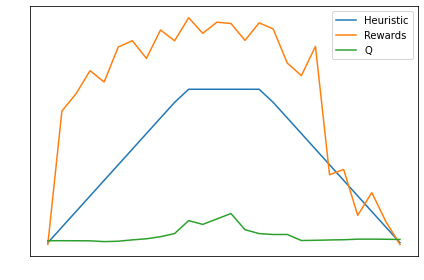

In [350]:
print(state.to_string())
print(evaluations_q)
plt.plot(states, evaluations_h)
plt.plot(states, evaluations_r)
plt.plot(states, evaluations_q)
plt.legend(["Heuristic", "Rewards", "Q"])
plt.tight_layout()
plt.show()
